# Brain Tumor Growth Modeling: Integrating Imaging and Computational Techniques

## Introduction

This Jupyter Notebook documents the complete workflow and methodologies implemented during the research project on brain tumor growth modeling.

### Overview
1. Segment brain tumors using a U-Net deep learning architecture.
2. Calculate tumor-specific parameters such as the growth rate and diffusion coefficient.
3. Solve the Fisher-Kolmogorov partial differential equation (PDE) to model tumor density and its progression.


### Notebook Outline
This notebook is structured into the following sections:
1. **Data Preprocessing**: Loading and preprocessing MRI data.
2. **Tumor Segmentation**: Implementation of the U-Net model for brain tumor segmentation.
3. **Parameter Calculation**: Computing growth rates and diffusion coefficients from segmented MRI images.
4. **PDE Solution**: Solving the Fisher-Kolmogorov equation analytically and numerically.
5. **Visualization and Results**: Visualizing tumor density and analyzing patient-specific results.

### Team Members
- Ahmed Salah  
- Amira Yasser  
- Mennat Allah Khalifa  
- Mo’men Mohamed  
- Mohamed Hamdy  
- Rawan Mohamed  
- Youssef Mohamed Wanis  


In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pydicom
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, LeakyReLU, concatenate
from tensorflow.keras.models import Model
import keras
import nibabel as nib
import numpy as np
import math
from PIL import Image
import os
import ants

2024-12-21 06:19:51.959576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-21 06:19:51.960561: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-21 06:19:51.970275: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-21 06:19:51.995313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734754792.041762   30779 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734754792.05

## Exploring and Saving the MRI Dataset

### About the Dataset
This dataset consists of MRI images stored in **DICOM (Digital Imaging and Communications in Medicine)** format, which is a standard for storing and transmitting medical imaging data. Each DICOM file contains both the image data and metadata, including patient information, imaging parameters, and acquisition details. 

For this demonstration, we focus on a single patient's dataset as a sample, rather than processing all the patients' data. This approach ensures clarity and simplicity while showcasing the workflow used for exploring and saving MRI images.

---

### Purpose
The primary goal of this section is to:
1. Explore the contents of a directory containing DICOM files.
2. Visualize the images using Python libraries.
3. Save the DICOM images as PNG files for further processing and analysis.

This step is crucial for preparing the dataset for segmentation and computational modeling tasks, as described in later sections of the notebook.

---

### Code Explanation

#### **1. Viewing DICOM Images**
The `view_dicom_directory` function:
- Lists all DICOM files in a specified directory.
- Reads and displays each DICOM file using the **PyDicom** and **Matplotlib** libraries.
- Prints the associated metadata for each file, offering insights into the imaging parameters.



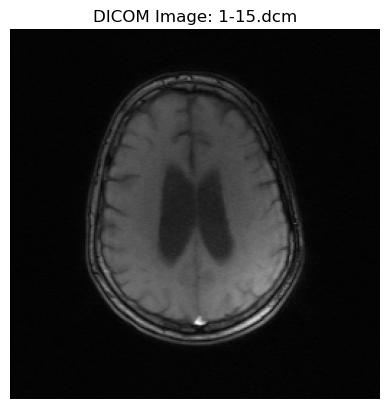


Metadata for 1-15.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.194611844595574965583510136695929788881
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.194611844595574965583510136695929788881
(0008,0020) Study Dat

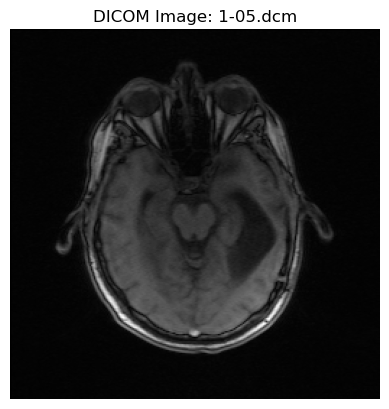


Metadata for 1-05.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.185320681463910516785980673508069740744
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.185320681463910516785980673508069740744
(0008,0020) Study Dat

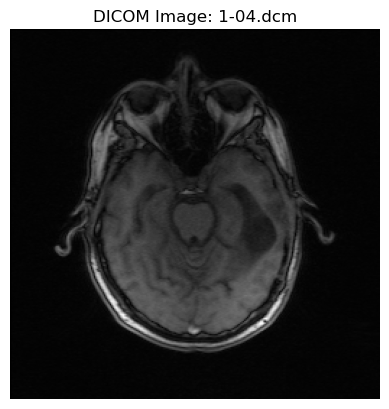


Metadata for 1-04.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.212748172335582797793234000266554596926
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.212748172335582797793234000266554596926
(0008,0020) Study Dat

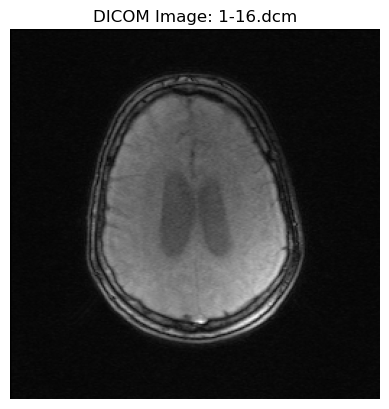


Metadata for 1-16.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.18141898637178877269553228120285659731
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.18141898637178877269553228120285659731
(0008,0020) Study Date 

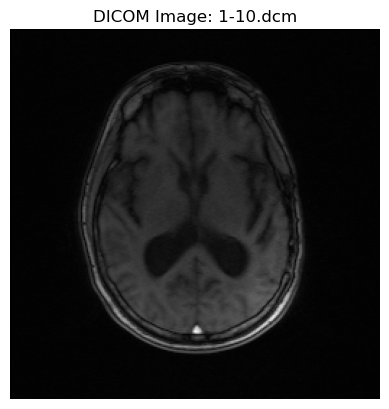


Metadata for 1-10.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.286856712701672494457474062034425769085
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.286856712701672494457474062034425769085
(0008,0020) Study Dat

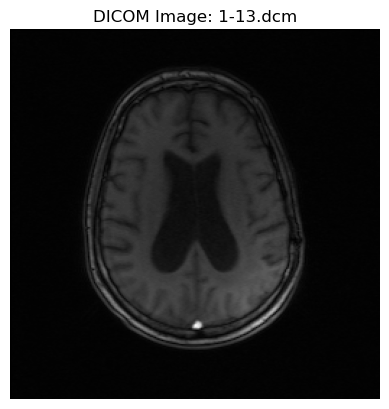


Metadata for 1-13.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.144943857862116853481472928147032518411
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.144943857862116853481472928147032518411
(0008,0020) Study Dat

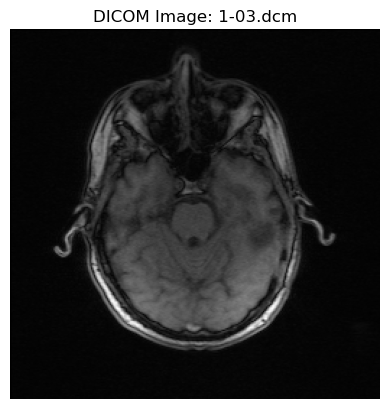


Metadata for 1-03.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.141464433396152344103913265149381938679
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.141464433396152344103913265149381938679
(0008,0020) Study Dat

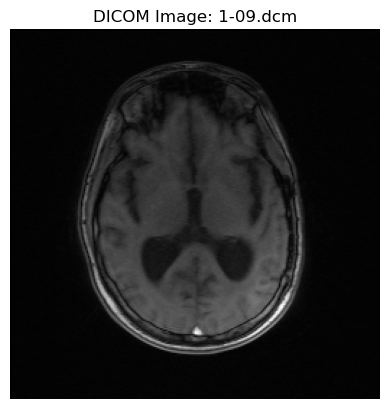


Metadata for 1-09.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.49153257819360657817327435201299808292
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.49153257819360657817327435201299808292
(0008,0020) Study Date 

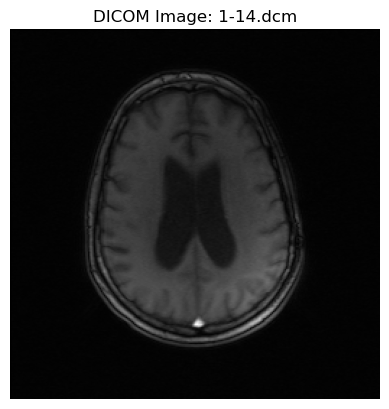


Metadata for 1-14.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.153653123196223272027588593825601459655
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.153653123196223272027588593825601459655
(0008,0020) Study Dat

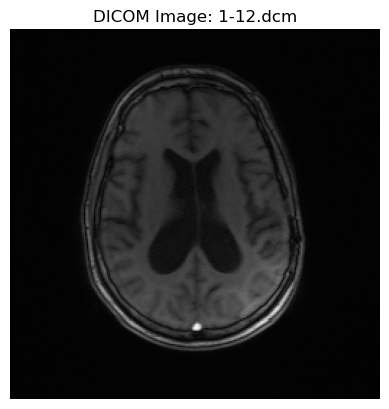


Metadata for 1-12.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.185929163538443811490994919090404092274
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.185929163538443811490994919090404092274
(0008,0020) Study Dat

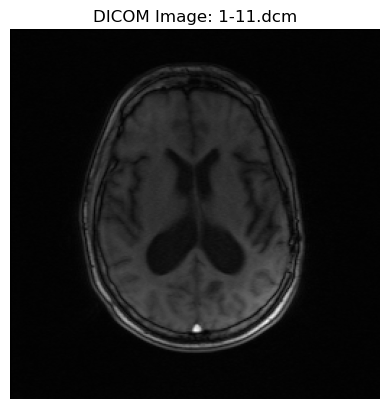


Metadata for 1-11.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.22277855006993096888162943478539523301
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.22277855006993096888162943478539523301
(0008,0020) Study Date 

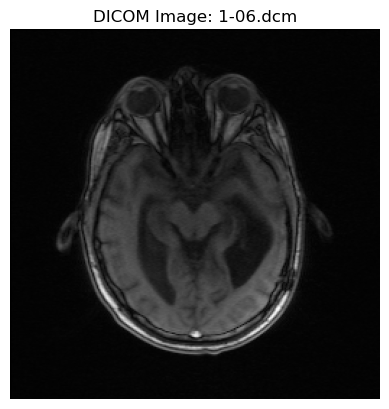


Metadata for 1-06.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.196933360088057636250480489905378761779
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.196933360088057636250480489905378761779
(0008,0020) Study Dat

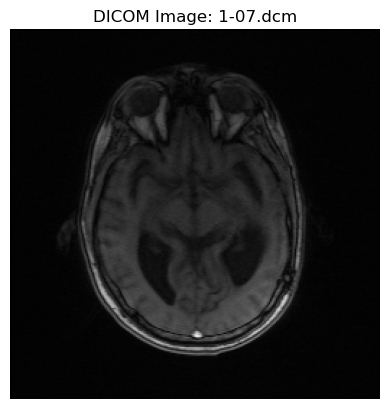


Metadata for 1-07.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.271963635082376482518420929302633106340
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.271963635082376482518420929302633106340
(0008,0020) Study Dat

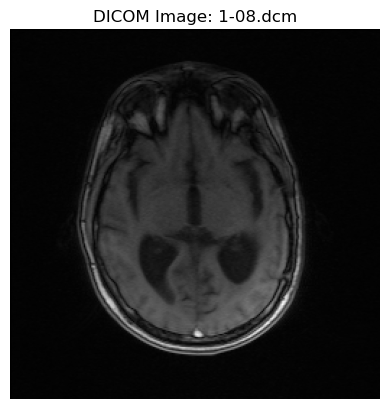


Metadata for 1-08.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.94284966620191884182015644251242303068
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.94284966620191884182015644251242303068
(0008,0020) Study Date 

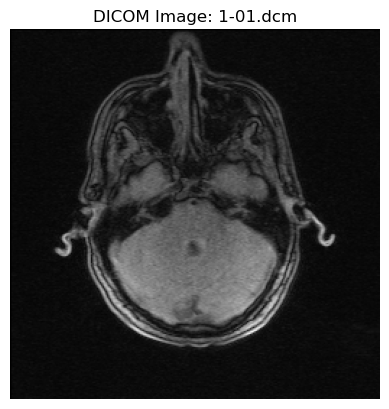


Metadata for 1-01.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.54182383184836024806384519660264735646
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.54182383184836024806384519660264735646
(0008,0020) Study Date 

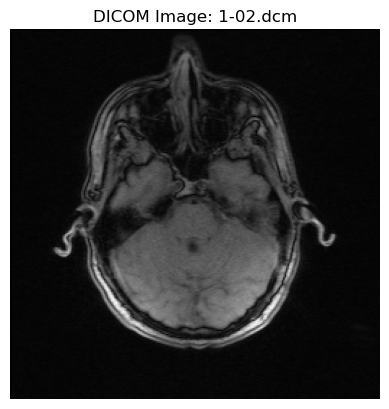


Metadata for 1-02.dcm:
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 192
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9328.50.16.49759339509256243038237336348165305951
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.27'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'ND']
(0008,0016) SOP Class UID                       UI: MR Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.16.49759339509256243038237336348165305951
(0008,0020) Study Date 

In [2]:
def view_dicom_directory(directory_path):
    """
    Open and display all DICOM (.dcm) files in a directory.

    Args:
    directory_path (str): Path to the directory containing DICOM files.
    """
    try:
        # List all files in the directory
        dicom_files = [file for file in os.listdir(directory_path) if file.endswith(".dcm")]
        
        if not dicom_files:
            print("No DICOM files found in the directory.")
            return
        
        for file_name in dicom_files:
            file_path = os.path.join(directory_path, file_name)
            
            # Read the DICOM file
            dicom_data = pydicom.dcmread(file_path)
            
            # Extract pixel array
            pixel_array = dicom_data.pixel_array
            
            # Display the image using matplotlib
            plt.imshow(pixel_array, cmap='gray')
            plt.title(f"DICOM Image: {file_name}")
            plt.axis("off")
            plt.show()
            
            # Print metadata
            print(f"\nMetadata for {file_name}:")
            print(dicom_data)
    except Exception as e:
        print(f"Error processing DICOM files in the directory: {e}")

# Example usage
# Replace 'your-directory-path' with the Kaggle directory path containing DICOM files
directory_path = "patient_data_set/7.000000-ax 10 flip-80754"
view_dicom_directory(directory_path)


In [3]:
def save_dicom_images(directory_path, save_path):
    """
    Open and save all DICOM (.dcm) files as images in a directory.

    Args:
    directory_path (str): Path to the directory containing DICOM files.
    save_path (str): Path to save the output images.
    """
    try:
        # Create the save directory if it doesn't exist
        os.makedirs(save_path, exist_ok=True)
        
        # List all DICOM files in the directory
        dicom_files = [file for file in os.listdir(directory_path) if file.endswith(".dcm")]
        
        if not dicom_files:
            print("No DICOM files found in the directory.")
            return
        
        for file_name in dicom_files:
            file_path = os.path.join(directory_path, file_name)
            
            # Read the DICOM file
            dicom_data = pydicom.dcmread(file_path)
            
            # Extract pixel array
            pixel_array = dicom_data.pixel_array
            
            # Plot and save the image
            plt.imshow(pixel_array, cmap='gray')
            plt.axis("off")
            
            # Save the image
            output_file = os.path.join(save_path, file_name.replace(".dcm", ".png"))
            plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
            plt.close()
            
            print(f"Saved: {output_file}")
    except Exception as e:
        print(f"Error saving DICOM images: {e}")

save_dicom_images("patient_data_set/7.000000-ax 10 flip-80754", "patient_data_set/PNG/day1")
save_dicom_images("patient_data_set/7.000000-ax 5 flip-99605", "patient_data_set/PNG/day2")

Saved: patient_data_set/PNG/day1/1-15.png
Saved: patient_data_set/PNG/day1/1-05.png
Saved: patient_data_set/PNG/day1/1-04.png
Saved: patient_data_set/PNG/day1/1-16.png
Saved: patient_data_set/PNG/day1/1-10.png
Saved: patient_data_set/PNG/day1/1-13.png
Saved: patient_data_set/PNG/day1/1-03.png
Saved: patient_data_set/PNG/day1/1-09.png
Saved: patient_data_set/PNG/day1/1-14.png
Saved: patient_data_set/PNG/day1/1-12.png
Saved: patient_data_set/PNG/day1/1-11.png
Saved: patient_data_set/PNG/day1/1-06.png
Saved: patient_data_set/PNG/day1/1-07.png
Saved: patient_data_set/PNG/day1/1-08.png
Saved: patient_data_set/PNG/day1/1-01.png
Saved: patient_data_set/PNG/day1/1-02.png
Saved: patient_data_set/PNG/day2/1-04.png
Saved: patient_data_set/PNG/day2/1-03.png
Saved: patient_data_set/PNG/day2/1-01.png
Saved: patient_data_set/PNG/day2/1-02.png


## Brain Tumor Segmentation with U-Net Architecture

### Purpose
This section describes the implementation and application of a U-Net model for segmenting brain tumors from MRI images. The U-Net architecture, widely used in biomedical image segmentation, is utilized to predict the tumor region from preprocessed MRI scans. The provided implementation includes the model definition, weight loading, and segmentation pipeline.

---

### U-Net Architecture
The U-Net model consists of two main parts:
1. **Encoder (Downsampling Path)**:
   - Extracts spatial features at multiple levels of abstraction using convolutional layers.
   - Incorporates **Batch Normalization** for stabilization and **Leaky ReLU** activation for non-linearity.
   - Includes max pooling for downsampling, reducing the spatial dimensions while preserving features.

2. **Decoder (Upsampling Path)**:
   - Reconstructs the segmentation mask by combining upsampled features with skip connections from the encoder.
   - Uses **Transposed Convolutions** for upsampling and concatenates encoder features to retain high-resolution details.

The network is designed to handle images of size `(256, 256, 3)` and outputs a single-channel segmentation mask of the same spatial dimensions.

---

### Key Components
1. **Convolutional Block (`conv_block`)**:
   - Performs two consecutive convolutional operations, followed by batch normalization and activation.
   - Provides an option for max pooling to reduce spatial dimensions in the encoder.

2. **Upsampling Block (`up_block`)**:
   - Upsamples the input feature map using transposed convolutions.
   - Combines the upsampled features with skip connections from the encoder for better reconstruction.

3. **U-Net Model (`unet`)**:
   - Combines the encoder and decoder blocks.
   - Outputs a segmentation mask using a sigmoid activation function, suitable for binary segmentation tasks.
   - Compiles the model with the Adam optimizer and Mean Squared Error (MSE) loss function.

---

### Code Highlights

#### **Model Definition**
The U-Net model is defined using Keras, with modular blocks for encoding, decoding, and skip connections. Key steps include:
- **Weight Initialization**: The model weights are initialized using the `he_normal` initializer for better convergence.
- **Compilation**: The model is compiled with an MSE loss to minimize pixel-wise differences between predicted and true masks.

#### **Weight Loading**
Pre-trained weights are loaded from an external file:
```python
model.load_weights(MODEL_PATH)


In [4]:
def conv_block(inputs, n_filters, max_pool=True):
    x = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(n_filters, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip = x
    if max_pool:
        next_layer = MaxPooling2D()(x)
    else:
        next_layer = x
    return next_layer, skip

# Upsampling block
def up_block(reg_inputs, skip_inputs, n_filters):
    x = Conv2DTranspose(n_filters, 3, 2, padding='same')(reg_inputs)
    x = concatenate([x, skip_inputs], axis=3)
    x = conv_block(x, n_filters, max_pool=False)[0]
    return x

# U-Net model
def unet(input_size=(256, 256, 3)):
    # Encoder block
    inputs = Input(shape=input_size, name='Input')
    cb1, cb1_skip = conv_block(inputs, 32)
    cb2, cb2_skip = conv_block(cb1, 64)
    cb3, cb3_skip = conv_block(cb2, 128)
    cb4, cb4_skip = conv_block(cb3, 256)
    cb5 = conv_block(cb4, 512, max_pool=False)
    
    # Decoder block
    up1 = up_block(cb5[0], cb4_skip, 256)
    up2 = up_block(up1, cb3_skip, 128)
    up3 = up_block(up2, cb2_skip, 64)
    up4 = up_block(up3, cb1_skip, 32)
    
    # Output
    conv1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', use_bias=False)(up4)
    bn = BatchNormalization()(conv1)
    act = LeakyReLU(0.2)(bn)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid', name='Output')(act)
    
    # Creating the model
    unet = Model(inputs=inputs, outputs=outputs)
    
    # Compiling the model
    unet.compile(optimizer=keras.optimizers.Adam(3e-4), loss='mean_squared_error')
    
    return unet

# Load the model architecture
model = unet()

# Load the weights into the model (assuming the weights file path is correct)
MODEL_PATH = "best_model.weights.h5"

# Load the weights (use by_name=True to match layer names)
try:
    model.load_weights(MODEL_PATH)
    print("Weights loaded successfully!")
except ValueError as e:
    print(f"Error loading weights: {e}")

# Check the model summary
model.summary()

# Optionally, you can plot the model to visualize the architecture
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=60)

W0000 00:00:1734754803.390896   30779 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Weights loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        864 │ Input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,216 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,864 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ leaky_re_lu_3[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]  

 Total params: 8,648,673 (32.99 MB)

 Trainable params: 8,642,721 (32.97 MB)

 Non-trainable params: 5,952 (23.25 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [5]:
def segment_image(image, model, input_size=(256, 256), threshold=0.5):
    """
    Preprocess an image, predict the segmentation mask, and visualize results.

    Args:
    - image (PIL.Image.Image or np.ndarray): Input image for segmentation.
    - model (Model): Trained U-Net model for segmentation.
    - input_size (tuple): Input size for the model (height, width).
    - threshold (float): Threshold for binary mask generation.

    Returns:
    - binary_mask (np.ndarray): Binary mask after applying the threshold.
    """
    # Convert PIL image to NumPy array if it is a PIL.Image.Image object
    if isinstance(image, Image.Image):
        image = np.array(image)  # Convert to NumPy array

    # Handle images that may have alpha channels
    if len(image.shape) == 3 and image.shape[-1] == 4:  # If image has RGBA channels
        image = image[..., :3]  # Convert to RGB

    # Ensure the image has 2D or 3D shape
    if len(image.shape) == 2:  # Grayscale
        image = np.expand_dims(image, axis=-1)  # Add channel dimension

    # Check if the image is 3D but with unexpected shape
    if len(image.shape) == 3 and image.shape[-1] not in [1, 3]:
        raise ValueError(f"Unexpected image shape: {image.shape}")

    # Ensure the image is uint8 for compatibility with PIL
    image = (image * 255).astype(np.uint8) if image.dtype != np.uint8 else image

    # Resize and normalize the image
    image_resized = np.array(Image.fromarray(image).resize(input_size)).astype('float32') / 255.0

    # Ensure the shape is (height, width, 3) with explicit channel dimension
    if image_resized.ndim == 2 or image_resized.shape[-1] == 1:
        image_resized = np.expand_dims(image_resized, axis=-1)  # Add channel dimension
        image_resized = np.repeat(image_resized, 3, axis=-1)  # Repeat grayscale RGB channels to mimic 3 channels.

    # Add batch size to model input dimensions
    image_input = np.expand_dims(image_resized, axis=0)  # Shape: (1, 256, 256, 3)

    # Predict using the model
    try:
        predicted_mask = model.predict(image_input)
    except ValueError as e:
        print("Error during model prediction. Check model input/output shapes.")
        print(e)
        return

    # Ensure predicted_mask is squeezed
    mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    # Apply threshold
    binary_mask = (mask > threshold).astype(np.float32)

    # Visualize the input image, raw mask, and binary mask
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray' if image.shape[-1] == 1 else None)
    plt.title("Registered Image")
    plt.axis('off')

    # Raw Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='viridis')
    plt.title("Raw Predicted Mask")
    plt.colorbar()
    plt.axis('off')

    # Binary Mask
    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Segmented Tumor")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return binary_mask


## MRI Image Registration and Synthetic Template Creation

This section provides a workflow for registering MRI images to a synthetic Gaussian-like template using the ANTsPy library. Registration is a critical preprocessing step for aligning medical images to a common reference frame, which improves the accuracy of downstream analyses.

---

### Code Explanation

#### **1. Converting MRI Images to ANTsImage (`convert_to_ants_image`)**
- Converts a NumPy array representation of an MRI image into an **ANTsImage** object.
- Allows optional specification of image spacing; defaults to uniform spacing if not provided.
- Essential for compatibility with the ANTsPy library, which operates on ANTsImage objects.

#### **2. Creating a Synthetic Template (`create_synthetic_template`)**
- Dynamically generates a Gaussian-like synthetic template to serve as a fixed image for registration:
  - **2D Images**: Creates a Gaussian blob in 2D using meshgrid and exponential functions.
  - **3D Images**: Extends the Gaussian blob generation to 3D.
- Normalizes the synthetic image to the range `[0, 1]` to ensure uniform intensity scaling.
- Converts the generated template to an ANTsImage with appropriate spacing.

#### **3. Registering MRI Images to the Template (`register_mri_image`)**
- Combines the above steps into a pipeline:
  1. **Converts** the input MRI NumPy array into an ANTsImage.
  2. **Creates** a synthetic Gaussian template as the fixed reference image.
  3. **Performs Registration**: Uses the ANTs SyN (Symmetric Normalization) algorithm to align the moving MRI image with the fixed synthetic template.
  4. **Extracts Warped Image**: Retrieves the registered (warped) version of the input MRI image.
  5. **Converts to NumPy**: Outputs the registered image as a NumPy array for further processing.

---

### Key Features
- **Synthetic Gaussian Templates**: Custom templates are generated dynamically, ensuring adaptability for varying image dimensions (2D or 3D).
- **ANTs Registration**: Utilizes the robust SyN algorithm for precise image alignment.
- **Error Handling**: Catches exceptions during registration to ensure graceful failure and debugging.

In [6]:
def convert_to_ants_image(mri_image_array, spacing=None):
    """
    Converts a numpy array into an ANTsImage with proper spacing.
    Args:
        mri_image_array (numpy.ndarray): Input MRI image as a numpy array.
        spacing (list or tuple): Optional, specify spacing for the ANTsImage.
    Returns:
        ANTsImage: Converted MRI image as ANTsImage.
    """
    if spacing is None:
        # Default to unit spacing if none provided
        spacing = [1.0] * len(mri_image_array.shape)
    
    # Convert numpy array to ANTsImage
    mri_ants_image = ants.from_numpy(mri_image_array, spacing=spacing)
    return mri_ants_image


def create_synthetic_template(mri_image):
    """
    Dynamically creates a synthetic Gaussian-like template matching the dimensions of the provided MRI image.
    Handles both 2D and 3D cases.
    Args:
        mri_image (ANTsImage): Input MRI image as an ANTsImage object.
    Returns:
        ANTsImage: Synthetic Gaussian-like template image.
    """
    # Get the shape of your MRI image to match dimensions
    shape = mri_image.shape

    # If the image is 2D, create a 2D Gaussian-like template
    if len(shape) == 2:
        print("Input MRI is 2D. Creating a 2D synthetic Gaussian-like template.")
        x, y = np.meshgrid(
            np.linspace(-1, 1, shape[0]),
            np.linspace(-1, 1, shape[1])
        )
        synthetic_data = np.exp(-(x**2 + y**2))
        spacing = [1.0, 1.0]  # Set uniform 2D spacing
    elif len(shape) == 3:
        print("Input MRI is 3D. Creating a 3D synthetic Gaussian-like template.")
        # Create 3D Gaussian blob
        x, y, z = np.meshgrid(
            np.linspace(-1, 1, shape[0]),
            np.linspace(-1, 1, shape[1]),
            np.linspace(-1, 1, shape[2]),
        )
        synthetic_data = np.exp(-(x**2 + y**2 + z**2))
        spacing = [1.0, 1.0, 1.0]  # Set uniform 3D spacing
    else:
        raise ValueError("Unsupported MRI image dimensionality.")

    # Normalize the synthetic image
    synthetic_data_min = synthetic_data.min()
    synthetic_data_max = synthetic_data.max()

    # Avoid division by zero
    if synthetic_data_max - synthetic_data_min != 0:
        synthetic_data = (synthetic_data - synthetic_data_min) / (synthetic_data_max - synthetic_data_min)
    else:
        synthetic_data = np.zeros_like(synthetic_data)

    # Convert numpy array to ANTsImage with proper spacing
    synthetic_template = ants.from_numpy(synthetic_data, spacing=spacing)

    # Debugging: Ensure no NaNs exist
    if np.isnan(synthetic_template.numpy()).any():
        print("Warning: NaNs found in synthetic template.")
        synthetic_template = ants.from_numpy(np.nan_to_num(synthetic_data), spacing=spacing)

    return synthetic_template


def register_mri_image(mri_image_array):
    """
    Dynamically creates a synthetic Gaussian-like template, performs registration with ANTs SyN,
    and returns the registered MRI image as a numpy array.
    Args:
        mri_image_array (numpy.ndarray): Input MRI image as a numpy array.
    Returns:
        numpy.ndarray: Registered image as a NumPy array.
    """
    try:
        # Step 1: Convert raw input array to ANTsImage
        mri_image_ants = convert_to_ants_image(mri_image_array)

        # Step 2: Create synthetic Gaussian-like fixed template
        synthetic_fixed_template = create_synthetic_template(mri_image_ants)

        # Step 3: Perform registration using ANTs SyN
        registration = ants.registration(
            fixed=synthetic_fixed_template,
            moving=mri_image_ants,
            type_of_transform="SyN",
        )

        # Step 4: Extract the warped moving image
        warped_image = registration["warpedmovout"]

        # Step 5: Convert back to numpy for downstream processing
        registered_image_array = warped_image.numpy()

        print("Registration complete.")
        return registered_image_array

    except Exception as e:
        print("Error during registration:", e)
        return None

## Converting, Registering, and Visualizing MRI Images

This section demonstrates a complete workflow for handling 2D MRI images in PNG format, converting them into the NIfTI file format, registering them to a standard reference frame, and converting them back to PNG for visualization.

---

### Purpose
This workflow is essential for:
1. Standardizing the format of MRI images using NIfTI, a common format in medical imaging.
2. Aligning images through registration to ensure consistency in spatial orientation.
3. Visualizing the processed images for analysis or further research.

---

### Workflow Steps

#### **1. Conversion of PNG to NIfTI**
- The images are loaded from PNG format using the **Pillow library**.
- They are converted into NumPy arrays and saved as NIfTI images using **NiBabel**.
- An identity affine transformation (`np.eye(4)`) is applied, as spatial orientation information is not explicitly available in the PNG files.


In [7]:
image1 = Image.open(r"patient_data_set/PNG/day1/1-02.png").convert("L")  
image_array = np.array(image1)
nifti_img = nib.Nifti1Image(image_array, affine=np.eye(4))
nib.save(nifti_img, "trial_image1.nii.gz")
image1 = nib.load("trial_image1.nii.gz")

image2 = Image.open(r"patient_data_set/PNG/day2/1-02.png").convert("L")  
image_array = np.array(image2)
nifti_img = nib.Nifti1Image(image_array, affine=np.eye(4))
nib.save(nifti_img, "trial_image2.nii.gz")
image2 = nib.load("trial_image2.nii.gz")

In [8]:
registered_image1 = register_mri_image(image1.get_fdata())
registered_image2 = register_mri_image(image2.get_fdata())

Error during registration: module 'ants' has no attribute 'from_numpy'
Error during registration: module 'ants' has no attribute 'from_numpy'


In [11]:
if registered_image1.ndim == 3:
    slice_index = registered_image1.shape[0] // 2  # Select the middle slice
    img_array_2d = registered_image1[slice_index, :, :]
else:
    # If the image is already 2D
    img_array_2d = registered_image1

# Normalize the image array to 0-255 for proper visualization
normalized_img = (img_array_2d - img_array_2d.min()) / (img_array_2d.max() - img_array_2d.min()) * 255
normalized_img = normalized_img.astype(np.uint8)  # Ensure it's in an 8-bit format

# Save the image as a PNG
output_path1 = "output_image1.png"
plt.imsave(output_path1, normalized_img, cmap='gray')
original1 = plt.imread(output_path1)

###########################################################################################################################

if registered_image2.ndim == 3:
    slice_index = registered_image2.shape[0] // 2  # Select the middle slice
    img_array_2d = registered_image2[slice_index, :, :]
else:
    # If the image is already 2D
    img_array_2d = registered_image2

# Normalize the image array to 0-255 for proper visualization
normalized_img = (img_array_2d - img_array_2d.min()) / (img_array_2d.max() - img_array_2d.min()) * 255
normalized_img = normalized_img.astype(np.uint8)  # Ensure it's in an 8-bit format

# Save the image as a PNG
output_path2 = "output_image2.png"
plt.imsave(output_path2, normalized_img, cmap='gray')
original2 = plt.imread(output_path2)

AttributeError: 'NoneType' object has no attribute 'ndim'

In [10]:
mask1 = segment_image(original1, model, threshold=0.8)
mask2 = segment_image(original2, model, threshold=0.8)

NameError: name 'original1' is not defined

## Tumor Volume Calculation and Growth Rate Estimation

This section explains how to compute the tumor volume from binary segmentation masks and estimate the tumor's growth rate over time using exponential growth modeling. These calculations are critical for understanding tumor progression and evaluating treatment effectiveness.

---

### Code Workflow

#### **1. Tumor Volume Calculation (`calc_volume`)**
- **Purpose**: Compute the volume of the tumor based on the binary segmentation mask of the tumor.
- **Method**:
  - Each pixel represents an area determined by the physical dimensions of the MRI slice.
  - The tumor volume is calculated as:
    \[
    \text{Volume} = \text{Number of Tumor Pixels} \times \text{Pixel Area (mm}^2\text{)} \times \text{Slice Thickness (mm)}
    \]
  - The volume is then converted from cubic millimeters (mm³) to cubic centimeters (cm³).


In [10]:
def calc_volume(mask):
    pixel_size_x = 1  # mm
    pixel_size_y = 1  # mm
    slice_thickness = 5  # mm
    num_tumor_pixels = np.sum(mask) 
    area_mm2 = num_tumor_pixels * (pixel_size_x * pixel_size_y)
    tumor_volume_mm3 = area_mm2 * slice_thickness
    tumor_volume_cm3 = tumor_volume_mm3 / 1000  # Convert mm³ to cm³
    return tumor_volume_cm3


In [11]:
binary_mask1 =(mask1 > 0.5).astype(np.uint8)

binary_mask2 = (mask2 > 0.5).astype(np.uint8)
volume_1 = calc_volume(binary_mask1)
volume_2 = calc_volume(binary_mask2)
print(volume_1)
print(volume_2)

NameError: name 'mask1' is not defined

In [ ]:
def calculate_tumor_growth_rate(volume1, volume2, time1, time2):
    """
    Calculate the exponential growth rate of a tumor based on its volume.
    
    Parameters:
        volume1 (float): Tumor volume at time1.
        volume2 (float): Tumor volume at time2.
        time1 (float): Time corresponding to volume1 (in days).
        time2 (float): Time corresponding to volume2 (in days).
        
    Returns:
        float: Growth rate per day.
    """
    if time2 <= time1:
        raise ValueError("time2 must be greater than time1.")
    if volume1 < 0 or volume2 <= 0:
        raise ValueError("Volumes must be positive values.")

    growth_rate = math.log(volume2 / volume1) / (time2 - time1)
    return  growth_rate


growth_rate = calculate_tumor_growth_rate(volume_1, volume_2,0, 2)
print(f"Growth rate: {growth_rate:.4f} cm3/day")